# Free Music Archive (FMA) Usage
- [Github: FMA](https://github.com/mdeff/fma/tree/master)
- Dataset: fma_small
- [FMA paper](https://arxiv.org/abs/1612.01840)

In [1]:
%matplotlib inline

import utils
import os
import numpy as np
import IPython.display as ipd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import utils as skl_utils
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from score import Audio

In [2]:
# Directory where mp3 are stored.
# AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
n = 3
ipd.display(tracks["track"].head(n))
ipd.display(tracks["album"].head(n))
ipd.display(tracks["artist"].head(n))
ipd.display(tracks["set"].head(n))

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small


In [4]:
# 已通過 utils.load 指定 "small" < "medium" < "large"
small_tracks = tracks[tracks["set", "subset"] <= "small"]
small_tracks.shape

ipd.display(small_tracks.head())

album                                                           \
         comments        date_created date_released engineer favorites  id   
track_id                                                                     
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4   1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4   6   
140             1 2008-11-26 01:49:59    2007-05-22      NaN         1  61   
141             0 2008-11-26 01:49:57    2009-01-16      NaN         1  60   

                                                                     \
                                                information listens   
track_id                                                              
2                                                   <p></p>    6073   
5                                                   <p></p>    6073   
10                                                      NaN   47632   
140       <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...    1300   
141       <p>A full ensamble of strings, drums, electron...    1304   

                                               ...       track           \
                                producer tags  ... information interest   
track_id                                       ...                        
2                                    NaN   []  ...         NaN     4656   
5                                    NaN   []  ...         NaN     1933   
10                                   NaN   []  ...         NaN    54881   
140       Alec K. Refearn, Rob Pemberton   []  ...         NaN     1593   
141                                  NaN   []  ...         NaN      839   

                                                                           \
         language_code                                            license   
track_id                                                                    
2                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
5                   en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
10                  en  Attribution-NonCommercial-NoDerivatives (aka M...   
140                 en  Attribution-Noncommercial-No Derivative Works ...   
141                 en  Attribution-Noncommercial-No Derivative Works ...   

                                                                     
         listens lyricist number publisher tags               title  
track_id                                                             
2           1293      NaN      3       NaN   []                Food  
5           1151      NaN      6       NaN   []          This World  
10         50135      NaN      1       NaN   []             Freeway  
140         1299      NaN      2       NaN   []  Queen Of The Wires  
141          725      NaN      4       NaN   []                Ohio  

[5 rows x 52 columns]

## Top-genres

In [5]:
print(f"{len(genres['top_level'].unique())} top-level genres\nTop-genres: ")
ipd.display(genres.loc[genres['top_level'].unique()].sort_values(by="top_level"))
print(small_tracks["track", "genre_top"].unique())

16 top-level genres
Top-genres: 


,#tracks,parent,title,top_level
genre_id,,,,
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
8,868,0,Old-Time / Historic,8
9,1987,0,Country,9
10,13845,0,Pop,10
12,32923,0,Rock,12
13,730,0,Easy Listening,13


['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']


## Features

In [6]:
ipd.display(features["mfcc"].head())

statistics   kurtosis                                                    \
number             01        02        03        04        05        06   
track_id                                                                  
2            3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
3            4.296755  1.399977  0.112535 -0.211170  0.032953 -0.023489   
5            2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10           5.076893  1.161854  2.095651  1.372743 -0.203574 -0.345354   
20          11.880132  4.085320  0.002655  1.518562  0.181947  0.339014   

statistics                                          ...        std             \
number            07        08        09        10  ...         11         12   
track_id                                            ...                         
2          -0.259252  0.146735  0.410656 -0.162872  ...  10.059609   8.601942   
3           0.150404  0.046454  0.033484 -0.064596  ...   8.771966  10.026867   
5           0.090260  0.152119  0.261731 -0.608905  ...   8.863638   9.581952   
10         -0.529139  0.561974  0.281350 -0.150672  ...   8.289734   7.985110   
20          0.367611  0.069932 -0.016032  0.026012  ...   7.706648   6.498904   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
2           9.284250  9.245516  8.520863  8.560472  7.651871  7.246555   
3           6.978541  7.650417  9.600357  7.222888  8.398293  7.285423   
5           8.895723  8.141456  8.201844  7.780963  7.132692  7.539753   
10          7.075400  6.972649  7.071393  7.270959  7.051070  6.928591   
20          6.845514  6.934421  7.019398  6.983841  6.813648  7.520811   

statistics                      
number            19        20  
track_id                        
2           7.077188  7.391859  
3           7.417791  8.777440  
5           8.452527  7.334442  
10          6.430473  6.186294  
20          7.098001  7.032246  

[5 rows x 140 columns]

In [7]:
# features.columns.droplevel(2).unique()
print(f"Top-level features:\n\t>>> {list(features.columns.unique(level=0))}\n")
print(f"Second-level features:\n\t>>> {list(features.columns.unique(level=1))}")
ipd.display(features['chroma_cqt'])
ipd.display(features['chroma_cens'])
ipd.display(features['mfcc'])

Top-level features:
	>>> ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse', 'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast', 'spectral_rolloff', 'tonnetz', 'zcr']

Second-level features:
	>>> ['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']


statistics  kurtosis                                                    \
number            01        02        03        04        05        06   
track_id                                                                 
2           4.518084  0.223714 -1.098686 -0.781633 -0.938433 -1.132679   
3          -0.855436 -0.883988 -0.992211 -0.675419 -0.361638 -0.927972   
5          -0.605479 -1.181325 -0.663084 -0.390240 -0.436532 -0.658291   
10          0.162342 -0.751456 -0.088175 -0.790742 -0.416584  0.101062   
20         -0.864132 -1.228160 -1.183112 -0.168118 -0.266643 -0.688895   
...              ...       ...       ...       ...       ...       ...   
155316      0.356892  0.224423  0.170139  0.671846  1.690435 -0.118576   
155317     -0.194967 -0.494831 -0.912692 -0.774431 -0.656996 -0.155823   
155318     -0.381190 -0.602954 -1.294749 -0.550978 -0.792375 -0.663617   
155319     -1.027920 -0.994997 -0.865478 -1.102854 -0.641891 -1.320030   
155320     -0.696268 -0.442217 -0.746215 -0.548019 -1.054853 -0.593899   

statistics                                          ...       std            \
number            07        08        09        10  ...        03        04   
track_id                                            ...                       
2          -0.909878 -0.496936 -0.367597 -0.263383  ...  0.265110  0.236233   
3           0.094254  0.944722 -0.084373 -0.930610  ...  0.254289  0.244836   
5          -1.038576 -1.353048 -0.331045 -0.708057  ...  0.233674  0.233186   
10          1.617054 -0.556345 -1.124511 -0.877715  ...  0.172637  0.253625   
20         -1.085411 -1.369968 -0.668337 -1.152202  ...  0.284157  0.236633   
...              ...       ...       ...       ...  ...       ...       ...   
155316     -0.170168  2.502295  1.087514  0.968454  ...  0.270259  0.172187   
155317     -0.186434  0.736048 -0.144138 -1.276117  ...  0.314778  0.234417   
155318     -0.566711 -0.471959 -0.396427 -0.555517  ...  0.305100  0.210706   
155319     -0.891576 -0.838095 -1.203336 -0.785602  ...  0.236442  0.266854   
155320     -0.746063 -1.089311 -0.668871 -1.453427  ...  0.263580  0.207191   

statistics                                                              \
number            05        06        07        08        09        10   
track_id                                                                 
2           0.240283  0.266694  0.253122  0.235398  0.224825  0.232748   
3           0.211848  0.245807  0.209122  0.225268  0.203094  0.249586   
5           0.226433  0.238600  0.269667  0.305429  0.241888  0.242494   
10          0.190772  0.167853  0.186787  0.201067  0.268620  0.224365   
20          0.253107  0.260458  0.273599  0.306296  0.235080  0.283211   
...              ...       ...       ...       ...       ...       ...   
155316      0.267569  0.232749  0.228858  0.208014  0.190080  0.231306   
155317      0.290585  0.249193  0.242535  0.207804  0.196039  0.304232   
155318      0.269578  0.221478  0.236264  0.226324  0.219592  0.249287   
155319      0.215424  0.284173  0.239037  0.238621  0.278407  0.234249   
155320      0.266769  0.231075  0.247463  0.291256  0.232360  0.313945   

statistics                      
number            11        12  
track_id                        
2           0.241133  0.204236  
3           0.248174  0.233538  
5           0.232426  0.242393  
10          0.196909  0.212375  
20          0.316214  0.257823  
...              ...       ...  
155316      0.181893  0.239071  
155317      0.209144  0.317447  
155318      0.208209  0.250519  
155319      0.244667  0.237648  
155320      0.224310  0.255950  

[106574 rows x 84 columns]

statistics  kurtosis                                                    \
number            01        02        03        04        05        06   
track_id                                                                 
2           7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3           1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5           0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10          3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20         -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   
...              ...       ...       ...       ...       ...       ...   
155316     -0.490129  0.463834  2.321970 -0.084352  1.662914  2.115189   
155317     -0.461559 -0.229601 -0.496632 -0.422033  0.130612 -0.263825   
155318      0.552473 -0.110498 -0.532014  0.263131 -0.224011 -0.530972   
155319     -0.176901  0.187208 -0.050664  0.368843  0.066005 -0.857354   
155320      0.489665  1.862421  0.854461 -0.103666 -0.249835  0.360283   

statistics                                          ...       std            \
number            07        08        09        10  ...        03        04   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.092350  0.077237   
3           1.366848  1.054094  0.108103  0.619185  ...  0.102759  0.090946   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.100257  0.072991   
10          1.770694  1.604566  0.521217  1.982386  ...  0.056647  0.118345   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.147100  0.112692   
...              ...       ...       ...       ...  ...       ...       ...   
155316     -0.237794  5.695442  0.830353  1.951819  ...  0.145356  0.106066   
155317     -0.628103 -0.082687 -0.229483 -0.492753  ...  0.178551  0.127296   
155318      1.713526  1.418444  1.325197  0.120333  ...  0.149176  0.098879   
155319     -0.780860  0.626281 -0.630938 -0.787229  ...  0.096664  0.129895   
155320     -0.366701  0.033578 -0.834606 -1.154845  ...  0.130722  0.092180   

statistics                                                              \
number            05        06        07        08        09        10   
track_id                                                                 
2           0.074284  0.077322  0.077279  0.068588  0.079606  0.085470   
3           0.075314  0.102431  0.083249  0.100854  0.089236  0.083384   
5           0.071584  0.076366  0.126677  0.131232  0.108912  0.101764   
10          0.080761  0.071630  0.083277  0.069644  0.104290  0.077502   
20          0.130581  0.126656  0.146840  0.165409  0.112400  0.157284   
...              ...       ...       ...       ...       ...       ...   
155316      0.171739  0.136452  0.126534  0.090267  0.093647  0.124365   
155317      0.165922  0.142604  0.123660  0.102164  0.109767  0.159251   
155318      0.134045  0.103426  0.089903  0.083497  0.084681  0.121973   
155319      0.093302  0.151940  0.115668  0.094326  0.120498  0.106149   
155320      0.137882  0.110525  0.111855  0.128800  0.116368  0.166231   

statistics                      
number            11        12  
track_id                        
2           0.085498  0.098219  
3           0.079806  0.071072  
5           0.089526  0.088002  
10          0.074136  0.090781  
20          0.178552  0.137254  
...              ...       ...  
155316      0.095462  0.120004  
155317      0.110519  0.184411  
155318      0.090587  0.111838  
155319      0.103376  0.103931  
155320      0.106998  0.109930  

[106574 rows x 84 columns]

statistics   kurtosis                                                    \
number             01        02        03        04        05        06   
track_id                                                                  
2            3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
3            4.296755  1.399977  0.112535 -0.211170  0.032953 -0.023489   
5            2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10           5.076893  1.161854  2.095651  1.372743 -0.203574 -0.345354   
20          11.880132  4.085320  0.002655  1.518562  0.181947  0.339014   
...               ...       ...       ...       ...       ...       ...   
155316       4.895152  5.361988  3.186483  0.510951 -0.143080  0.342237   
155317       0.040857  1.752112  0.442188 -0.380960 -0.739809 -0.023362   
155318       0.581889 -0.129386  0.662489  1.025676  0.170532  1.827692   
155319       5.164501  3.716359  2.881116  3.273014  0.707058  1.951918   
155320       4.619462  1.234909  1.236056  0.335577  0.009484  1.682914   

statistics                                          ...        std             \
number            07        08        09        10  ...         11         12   
track_id                                            ...                         
2          -0.259252  0.146735  0.410656 -0.162872  ...  10.059609   8.601942   
3           0.150404  0.046454  0.033484 -0.064596  ...   8.771966  10.026867   
5           0.090260  0.152119  0.261731 -0.608905  ...   8.863638   9.581952   
10         -0.529139  0.561974  0.281350 -0.150672  ...   8.289734   7.985110   
20          0.367611  0.069932 -0.016032  0.026012  ...   7.706648   6.498904   
...              ...       ...       ...       ...  ...        ...        ...   
155316      0.771449 -0.184232  0.143237  0.009016  ...   7.401937   6.629143   
155317      0.264786  0.072084  0.295485  0.535544  ...   6.734644   6.955739   
155318     -0.189439  1.141878  0.022045  0.175235  ...   7.061307   6.943147   
155319     -0.151555  0.230036 -0.327132  1.182421  ...   7.300332   5.971618   
155320      0.317069 -0.128262  0.076033  0.112258  ...   7.538454   7.840639   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
2           9.284250  9.245516  8.520863  8.560472  7.651871  7.246555   
3           6.978541  7.650417  9.600357  7.222888  8.398293  7.285423   
5           8.895723  8.141456  8.201844  7.780963  7.132692  7.539753   
10          7.075400  6.972649  7.071393  7.270959  7.051070  6.928591   
20          6.845514  6.934421  7.019398  6.983841  6.813648  7.520811   
...              ...       ...       ...       ...       ...       ...   
155316      5.860062  6.230947  5.923375  5.586200  5.516872  5.755764   
155317      6.662989  6.478699  6.019901  5.757353  5.280114  5.674062   
155318      6.522048  6.780707  6.311563  5.789986  5.466107  5.607614   
155319      6.355647  5.602213  5.887583  5.110033  5.407447  5.317993   
155320      6.794503  6.431658  6.400701  6.733516  5.603289  5.868379   

statistics                      
number            19        20  
track_id                        
2           7.077188  7.391859  
3           7.417791  8.777440  
5           8.452527  7.334442  
10          6.430473  6.186294  
20          7.098001  7.032246  
...              ...       ...  
155316      5.105072  5.019556  
155317      5.541949  5.266131  
155318      5.685448  5.449005  
155319      5.187994  5.260817  
155320      6.128483  5.550875  

[106574 rows x 140 columns]

In [8]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks["track", "genre_top"] == "Hip-Hop" # return track_id and bool
genre2 = tracks["track", "genre_top"] == "Folk"
genre3 = tracks["track", "genre_top"] == "Experimental"
mfcc_genres = features.loc[small & (genre1 | genre2 | genre3), "mfcc"]
ipd.display(mfcc_genres["kurtosis"])

number,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
track_id,,,,,,,,,,,,,,,,,,,,
2,3.856789,1.541901,0.000816,0.330728,0.118731,-0.342687,-0.259252,0.146735,0.410656,-0.162872,-0.029920,0.430621,-0.225081,-0.303092,-0.190764,-0.052871,-0.151794,-0.000590,0.075492,0.002595
5,2.624517,2.415293,0.440233,-0.782131,-0.771069,-0.724216,0.090260,0.152119,0.261731,-0.608905,0.096892,-0.248479,0.159848,0.637849,0.192881,0.286125,-0.066113,0.363365,0.614379,0.131038
140,0.384906,1.203378,0.429393,0.639471,-0.080144,-0.440946,-0.432567,-0.126163,0.507695,0.408915,0.024341,0.113680,-0.160073,0.272321,0.280109,0.434392,-0.011030,0.454063,0.653689,0.788133
141,-0.038922,4.771146,-0.378949,-0.309047,-0.661308,-0.531602,0.029186,0.662524,-0.084562,0.965640,0.199449,-0.041373,-0.062308,-0.122510,-0.096526,0.042070,0.446569,0.446622,0.083110,0.150460
148,1.920421,0.527838,0.428367,2.585772,0.087255,-0.644727,0.720608,0.571477,-0.195432,0.462215,1.688170,0.635479,-0.107278,1.260841,0.275877,1.087932,0.352015,2.294574,1.547981,1.038294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154306,2.034168,0.744026,2.439629,0.832603,0.902451,0.021949,0.564807,0.647145,0.213224,0.245574,-0.004954,0.687432,0.424508,-0.044966,0.213205,0.026821,-0.272517,0.032714,0.573276,-0.111298
154307,-0.120522,0.522564,0.772077,-0.631063,-0.439495,-0.579385,-0.435570,-0.253491,-0.057322,-0.178522,-0.392874,-0.405859,0.136507,-0.162760,-0.073056,-0.130579,-0.183856,-0.377151,-0.447236,-0.585146
154308,0.486471,2.039885,1.065340,1.553311,1.149207,1.233508,0.740646,-0.296303,0.002152,0.429307,0.277521,0.144607,-0.407323,-0.346851,-0.196636,-0.012651,0.119894,0.038948,-0.411888,-0.218644


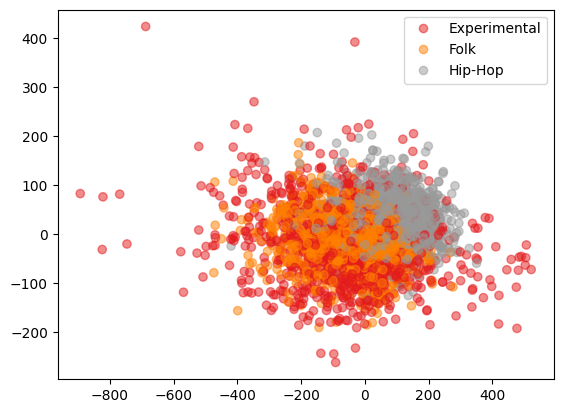

In [9]:
pca = PCA(n_components=2)
X = pca.fit_transform(mfcc_genres)

Y = tracks.loc[small & (genre1 | genre2 | genre3), ("track", "genre_top")]
le = LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

sc = plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='Set1', alpha=0.5)
plt.legend(sc.legend_elements()[0], le.classes_, title="")
plt.show()

## Classification

In [10]:
small = tracks['set', 'subset'] <= 'small'
train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

X_train = features.loc[small & train, "mfcc"]
X_test = features.loc[small & test, "mfcc"]
Y_train = tracks.loc[small & train, ('track', 'genre_top')]
Y_test = tracks.loc[small & test, ('track', 'genre_top')]

print('{} training examples, {} testing examples'.format(Y_train.size, Y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(Y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [11]:
X_train, Y_train = skl_utils.shuffle(X_train, Y_train, random_state=1)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = SVC()
clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test)
print('Accuracy: {:.2%}'.format(score))
X_test.shape


Accuracy: 46.38%


(800, 140)

In [38]:

audio = Audio(r"D:\Code\PyMusic\src\download\Ct6BUPvE2sM.mp3")
_, _, mfcc_stats = audio.get_mfcc()
stats = np.array(mfcc_stats.to_array()).flatten().reshape(1, -1)
stats = scaler.transform(stats)
pred = clf.predict(stats)
print(pred)

['Experimental']


In [32]:
Y_train

track_id
104065              Pop
52642        Electronic
115272    International
27609     International
43621              Folk
              ...      
29045               Pop
127205              Pop
110449    International
5936               Folk
126720     Instrumental
Name: (track, genre_top), Length: 6400, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']